In [1]:
from matplotlib import pyplot as plt
import numpy as np
from poisson_numcodecs import Poisson, calibrate
import zarr

### Load example data and estimate `zero_level` and `photon_sensitivity` 

In [2]:
data = np.load('../tests/data/data1.npz')['data']

In [3]:
# for bright images use count_weight_gamma=1
# for photon-starved images with few cells use count_weight_gamma = 0.001
# Otherwise, use the default
calibrator = calibrate.RasterCalibratePhotons(data)
[photon_sensitivity, dark_signal] = calibrator.get_photon_sensitivity_parameters()  

Fitting a single line, a single attempt will be made, since this is a convex problem.
Attempt 1 - Error: 368943458.9627315
Found lines: [[   148.51741003 -23318.53634348]]


In [4]:
[photon_sensitivity, dark_signal]

[array([148.51741003]), array([157.00877317])]

The slope and x-intercept for the photon transfer curve yield the photon sensitivity and the zero level.

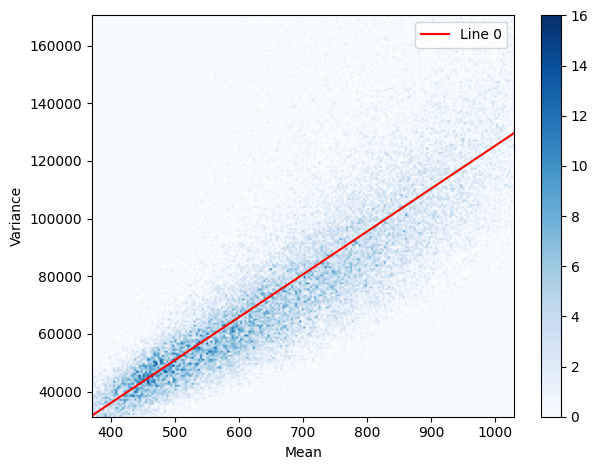

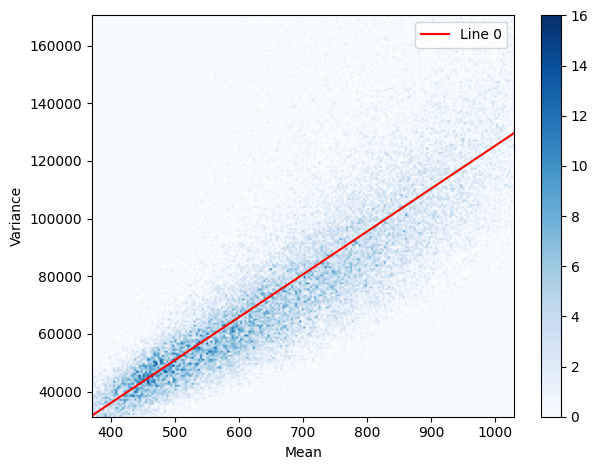

In [5]:
calibrator.plot_poisson_curve()

### Illustrate image compression using numcodecs / zarr

In [6]:
# instantiate Poisson object
poisson_filter = Poisson(photon_sensitivity=photon_sensitivity[0], dark_signal=dark_signal[0], beta=0.5, use_lookup=False)

In [7]:

chunk_shape = (1, data.shape[1], data.shape[2])
zarr_array = zarr.open('zarr_array.zarr', mode='w' , chunks=chunk_shape, shape=data.shape, dtype=data.dtype, filters=[poisson_filter])
zarr_array[...] = data

In [8]:
zarr_array.info

Type,zarr.core.Array
Data type,int16
Shape,"(300, 200, 200)"
Chunk shape,"(1, 200, 200)"
Order,C
Read-only,False
Filter [0],"Poisson(beta=0.5, dark_signal=157.00877317329594, decoded_dtype='int16', encoded_dtype='uint8', photon_sensitivity=148.5174100286664, use_lookup=False)"
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,24000000 (22.9M)
No. bytes stored,9885364 (9.4M)


# RESTART THE KERNEL
Restart the kernel manually to test zarr loading

In [9]:
import matplotlib.pyplot as plt
import zarr
from poisson_numcodecs import Poisson

# you don't need to import poisson_numcodecs but it must be installed

In [10]:
# open zarr
z_reopened = zarr.open('zarr_array.zarr', mode='r')
z_reopened.info

Type,zarr.core.Array
Data type,int16
Shape,"(300, 200, 200)"
Chunk shape,"(1, 200, 200)"
Order,C
Read-only,True
Filter [0],"Poisson(beta=0.5, dark_signal=157.00877317329594, decoded_dtype='int16', encoded_dtype='uint8', photon_sensitivity=148.5174100286664, use_lookup=False)"
Compressor,"Blosc(cname='lz4', clevel=5, shuffle=SHUFFLE, blocksize=0)"
Store type,zarr.storage.DirectoryStore
No. bytes,24000000 (22.9M)
No. bytes stored,9885364 (9.4M)


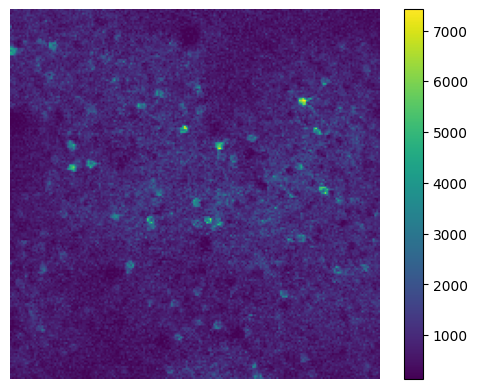

In [11]:
# show a decompressed frame
plt.imshow(z_reopened[10,:,:])
plt.axis(False)
plt.colorbar()

We compare compressed data with raw data to see if there is any structure in the difference

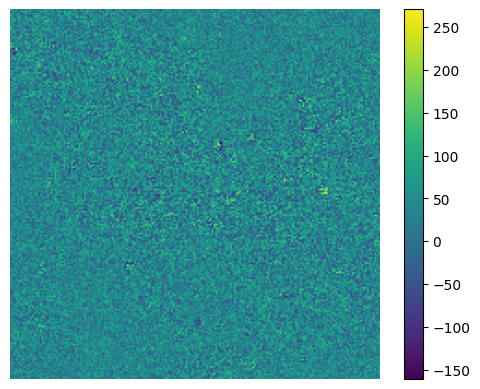

In [12]:
z_diff = z_reopened[:,:,:] - data[:,:,:]
plt.imshow(z_diff[10,:,:])
plt.axis(False)
plt.colorbar()

Average of the difference should be close to null?

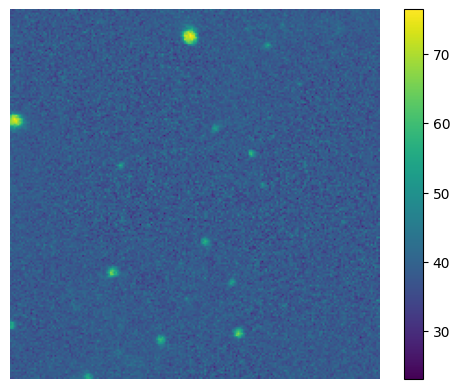

In [13]:
projection = np.mean(z_diff, axis=0)
plt.imshow(projection)
plt.axis(False)
plt.colorbar()

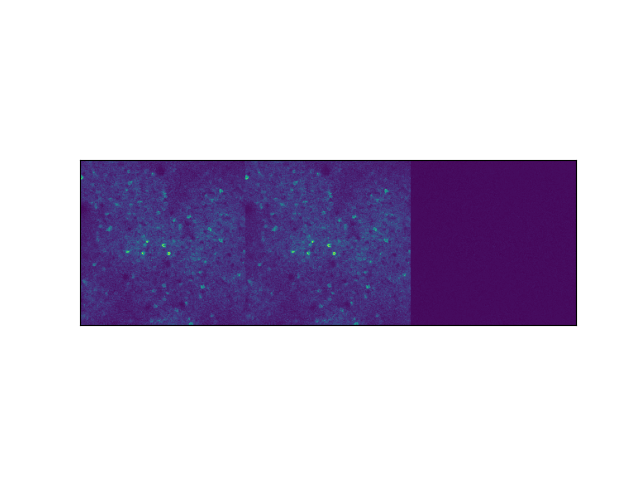

In [14]:
from mpl_interactions import hyperslicer

%matplotlib ipympl
plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# We merge raw, reconstructed and difference images into a single array
# to compare them side by side
merged = np.concatenate([data, z_reopened[:,:,:], z_diff], axis=2)
view = hyperslicer(merged, play_buttons=True)